# Aaron Kohn
## Final Project; Mileston 3
### Universal Studio Ratings Sentiment Analysis

The data set below contains ratings and reviews for three Universal Studio Parks. This part of the analysis attempts to use sentiment anlysis to predict the rating based on the review. As can be seen below while not perfect in predicting the exact rating the models preform quite well in preicting overall positive or negative reviews. Some leeway must be provided to account for indvidual ranking flictuations. An attempt is made to see if the model can be extended to rate indvidual sentences. Based on my understanding this does not seem to have similar success.

In [1]:
# Import packages
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix

In [2]:
# Load data
universal_df = pd.read_csv('universal_studio_branches.csv')

In [3]:
# View data
universal_df.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [4]:
# Check for duplicates
print(sum(universal_df.duplicated(subset = ['review_text'])))
print(sum(universal_df.duplicated(subset = ['review_text', 'rating'])))
universal_df.drop_duplicates(subset = ['review_text', 'rating'], inplace=True)
print(sum(universal_df.duplicated()))
universal_df.drop(['reviewer'], axis=1, inplace=True)

57
55
0


In [5]:
universal_df.head()

,rating,written_date,title,review_text,branch
0,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [6]:
# Get part of speech tags for title and reviews
universal_df['tagged_title'] = universal_df['title'].apply(lambda x : pos_tag(word_tokenize(x))) # Ad
universal_df['tagged_review'] = universal_df['review_text'].apply(lambda x : pos_tag(word_tokenize(x))) # Ad

In [7]:
# Preform nltk sentiment analysis to predict rating based on review
sia = SentimentIntensityAnalyzer()
universal_df['review_sentiment_compound'] = universal_df['review_text'].apply(lambda x : sia.polarity_scores(x)['compound'])
def convert(n):
    # Convert returned result from -1 to 1 scale to standard 1-5 rating scale
    x = n + 3 + n  # Formula for converting scores
    return round(x)
universal_df['sentiment_rating'] = universal_df['review_sentiment_compound'].apply(lambda x : convert(x))

In [8]:
universal_df.head()

,rating,written_date,title,review_text,branch,tagged_title,tagged_review,review_sentiment_compound,sentiment_rating
0,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,"[(Universal, NNP), (is, VBZ), (a, DT), (comple...","[(We, PRP), (went, VBD), (to, TO), (Universal,...",-0.9400,1
1,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,"[(Food, NN), (is, VBZ), (hard, JJ), (to, TO), ...","[(The, DT), (food, NN), (service, NN), (is, VB...",-0.8209,1
2,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,"[(Disappointed, JJ)]","[(I, PRP), (booked, VBD), (this, DT), (vacatio...",0.6194,4
3,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,"[(My, PRP$), (opinion, NN)]","[(When, WRB), (a, DT), (person, NN), (tries, V...",0.3400,4
4,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,"[(The, DT), (Bourne, NNP), (Stuntacular, NNP),...","[(Ok, NNP), (,, ,), (I, PRP), (ca, MD), (n't, ...",0.9749,5


In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

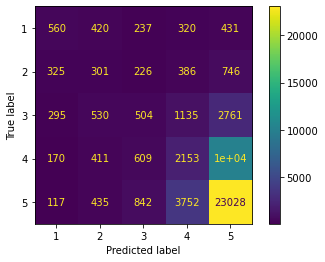

In [11]:
# Display confusion matrix of results
mat = ConfusionMatrixDisplay(confusion_matrix(universal_df['rating'], universal_df['sentiment_rating']),
                            display_labels=['1','2','3','4','5'])
mat.plot()



In [12]:
# Attempt as above to predict ratings from title of rating 
universal_df['title_sentiment_compound'] = universal_df['title'].apply(lambda x : sia.polarity_scores(x)['compound'])
def convert(n):
    x = n + 3 + n
    return round(x)
universal_df['title_sentiment_rating'] = universal_df['title_sentiment_compound'].apply(lambda x : convert(x))

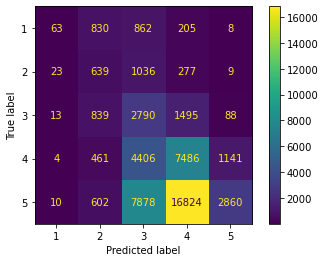

In [13]:
mat1 = ConfusionMatrixDisplay(confusion_matrix(universal_df['rating'], universal_df['title_sentiment_rating']),
                            display_labels=['1','2','3','4','5'])
mat1.plot()


In [31]:
# Accuracy, precision, recall, and f1 scores for sentiment analysis of reviews
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
print('Accuracy: ',accuracy_score(universal_df['rating'], universal_df['sentiment_rating']))
score_list = precision_recall_fscore_support(universal_df['rating'], universal_df['sentiment_rating']) # Get precision, recall, and f1 scores
print('Precision:', score_list[0])
print('Recall:   ', score_list[1])
print('F1 score: ', score_list[2])

Accuracy:  0.5220554976499047
Precision: [0.38173142 0.14353839 0.20843672 0.27794991 0.62034967]
Recall:    [0.28455285 0.15171371 0.09645933 0.15950511 0.81734933]
F1 score:  [0.32605531 0.14751286 0.13188539 0.20269252 0.70535263]


In [17]:
# View summary statistics of results
universal_df.describe()

,rating,review_sentiment_compound,sentiment_rating,title_sentiment_compound,title_sentiment_rating
count,50849.000000,50849.000000,50849.000000,50849.000000,50849.000000
mean,4.257173,0.715883,4.513442,0.323073,3.607721
std,1.046473,0.448185,0.968805,0.366374,0.738801
min,1.000000,-0.998800,1.000000,-0.911400,1.000000
25%,4.000000,0.718400,4.000000,0.000000,3.000000
50%,5.000000,0.905900,5.000000,0.440400,4.000000
75%,5.000000,0.965300,5.000000,0.624900,4.000000
max,5.000000,0.999900,5.000000,0.978300,5.000000


In [18]:
# One sample of models performance on sentance by sentance of review.
q = sent_tokenize(universal_df['review_text'][0]) # split first review into sentances
for x in q:
    print(x, sia.polarity_scores(x)) # Print the sentance and the scores

We went to Universal over Memorial Day weekend and it was a total train wreck. {'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'compound': -0.4404}
We waited to get in the parking lot for about forty minutes. {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
We paid for prime parking to make up for all the wasted time. {'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.4939}
Then we paid extra for the express pass 2-park tickets only to be turned away and sent to guest services bc the app didn’t show the bar code. {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
The line at guest services took forever. {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
They are clearly understaffed. {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.4019}
We were sent to yet another guest services line because we had the express passes! {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Also took ages! {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
We spent nearly 2 hours just t

As can be seen many sentances scored as neutral appear to be intended as negative. Complaints about long wait times are rated as neutral.

In [19]:
# attempt to use Keras classifier to predict rating
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import scipy
from sklearn.model_selection import train_test_split

In [20]:
def clean_text(text):
    # Clean text, remove end of lines, remove uppercase letters, puctuation and numbers.
    text = text.replace('\n','')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    r=re.compile(r'\d')
    text = r.sub('', text)
    text = text.strip()
    return text
def stringit(x):
    # Convert list of words to string
    y = " "
    
    return y.join(x)
def normalize_text(df, col, add_on= ''):
    # Clean, Tokenize, and stem text. Remove stopwords from text. Returns a cleaned column, a tokenized column, and a column of tokens as string
    df['clean_txt' + add_on] = df[col].apply(lambda x : clean_text(x))
    df['tokenized_txt' + add_on] = df['clean_txt' + add_on].apply(lambda x : word_tokenize(x))
    stopword = stopwords.words('english') # Set stopwords
    df['tokenized_txt' + add_on] = df['tokenized_txt' + add_on].apply(lambda x : [word for word in x if word not in stopword]) # Remove stopwords for each row
    porter = nltk.stem.PorterStemmer() # Create stemmer
    df['stemmed_txt' + add_on] = df['tokenized_txt' +add_on].apply(lambda x : [porter.stem(word) for word in x])
    df['stemmed_string' + add_on] = df['stemmed_txt' + add_on].apply(lambda x : stringit(x))

In [21]:
normalize_text(universal_df, 'review_text', add_on= '_review') # Apply normilization

In [22]:
universal_df.head()

,rating,written_date,title,review_text,branch,tagged_title,tagged_review,review_sentiment_compound,sentiment_rating,title_sentiment_compound,title_sentiment_rating,clean_txt_review,tokenized_txt_review,stemmed_txt_review,stemmed_string_review
0,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,"[(Universal, NNP), (is, VBZ), (a, DT), (comple...","[(We, PRP), (went, VBD), (to, TO), (Universal,...",-0.9400,1,-0.6588,2,we went to universal over memorial day weekend...,"[went, universal, memorial, day, weekend, tota...","[went, univers, memori, day, weekend, total, t...",went univers memori day weekend total train wr...
1,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,"[(Food, NN), (is, VBZ), (hard, JJ), (to, TO), ...","[(The, DT), (food, NN), (service, NN), (is, VB...",-0.8209,1,-0.1027,3,the food service is horrible i’m not reviewing...,"[food, service, horrible, ’, reviewing, food, ...","[food, servic, horribl, ’, review, food, ’, wa...",food servic horribl ’ review food ’ wait time ...
2,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,"[(Disappointed, JJ)]","[(I, PRP), (booked, VBD), (this, DT), (vacatio...",0.6194,4,-0.4767,2,i booked this vacation mainly to ride hagrid m...,"[booked, vacation, mainly, ride, hagrid, motor...","[book, vacat, mainli, ride, hagrid, motorcycl,...",book vacat mainli ride hagrid motorcycl advent...
3,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,"[(My, PRP$), (opinion, NN)]","[(When, WRB), (a, DT), (person, NN), (tries, V...",0.3400,4,0.0000,3,when a person tries the test seat for the ride...,"[person, tries, test, seat, rides, gets, green...","[person, tri, test, seat, ride, get, green, li...",person tri test seat ride get green light go l...
4,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,"[(The, DT), (Bourne, NNP), (Stuntacular, NNP),...","[(Ok, NNP), (,, ,), (I, PRP), (ca, MD), (n't, ...",0.9749,5,0.0000,3,ok i cant stress enough to anyone and everyone...,"[ok, cant, stress, enough, anyone, everyone, g...","[ok, cant, stress, enough, anyon, everyon, go,...",ok cant stress enough anyon everyon go univers...


In [33]:
# Select sample cretae train, test split
corpus = universal_df.sample(n=50000)
X = corpus['stemmed_string_review']
y = corpus['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.3, random_state=11)

In [34]:
# Build Keras Classifier network
N_FEATURES = 5000 # Set number of features
N_CLASSES = 5 # Set number of classes

def build_network():
    # Compile a neural network
    nn = Sequential()
    nn.add(Dense(500, activation='relu', input_shape= (N_FEATURES,)))
    nn.add(Dense(150, activation= 'relu'))
    nn.add(Dense(N_CLASSES, activation= 'softmax'))
    nn.compile(
        loss= 'categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return nn

In [35]:
vectorizer = TfidfVectorizer( max_features= 5000) # Create vectorizer
tfidf_train = vectorizer.fit_transform(X_train) # Return features and tfidf values for training set
tfidf_train.sort_indices() # Sort by index (required by tensorflow)
tfidf_val = vectorizer.transform(X_val)  # Return tfidf values for test set
tfidf_val.sort_indices()

In [36]:
dnn =  KerasClassifier(build_fn= build_network,
                        epochs= 100,
                        batch_size=128,
                      verbose=10)
train_k = dnn.fit(tfidf_train, y_train) # Train model

confusion_matrix(y_val, dnn.predict(tfidf_val)) # Return confusion matrix of test set

Epoch 1/100


C:\Users\aarme\anaconda3.2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

array([[ 280,  122,   89,   39,   58],
       [ 165,  116,  179,   68,   80],
       [ 130,  179,  433,  460,  375],
       [  65,   77,  373, 1312, 2105],
       [  54,   55,  253, 1501, 6432]], dtype=int64)

C:\Users\aarme\anaconda3.2\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy:  0.8665263820330783
Precision: [0.79170685 0.76399791 0.807963   0.83089544 0.90459096]
Recall:    [0.83434959 0.7358871  0.76899522 0.79537709 0.93014836]
F1 score:  [0.81246907 0.74967908 0.78799765 0.8127484  0.91719166]


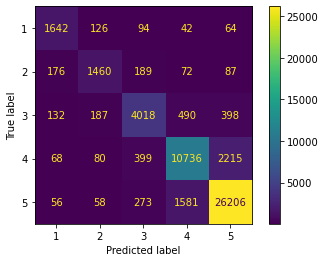

In [37]:
tfidf_full = vectorizer.transform(universal_df['stemmed_string_review']) # Return tfidf values for full data set
tfidf_full.sort_indices() # Sort by index (required by tensorflow)
pred_full = dnn.predict(tfidf_full) # Apply model to full data set
accuracy = accuracy_score(universal_df['rating'], pred_full) # Get accuracy of model
score_list = precision_recall_fscore_support(universal_df['rating'], pred_full) # Get precision, recall, and f1 scores
print('Accuracy: ',accuracy)
print('Precision:', score_list[0])
print('Recall:   ', score_list[1])
print('F1 score: ', score_list[2])
mat = ConfusionMatrixDisplay(confusion_matrix(universal_df['rating'], pred_full),
                            display_labels=['1','2','3','4','5'])
mat.plot()

In [38]:
# Attempt to apply model on sentences 
q = sent_tokenize(universal_df['review_text'][0]) # get sentences

tf = vectorizer.transform(q) # Use tfidf vector to transform sentences
tf.sort_indices()
b = 0
for x in tf: # Loop through sentences and print score and sentence
    pr = dnn.predict(x)
    print(pr, q[b])
    b+=1
    print('*' * 25)
   

C:\Users\aarme\anaconda3.2\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[5.] We went to Universal over Memorial Day weekend and it was a total train wreck.
*************************
[5.] We waited to get in the parking lot for about forty minutes.
*************************
[5.] We paid for prime parking to make up for all the wasted time.
*************************
[5.] Then we paid extra for the express pass 2-park tickets only to be turned away and sent to guest services bc the app didn’t show the bar code.
*************************
[5.] The line at guest services took forever.
*************************
[5.] They are clearly understaffed.
*************************
[5.] We were sent to yet another guest services line because we had the express passes!
*************************
[5.] Also took ages!
*************************
[5.] We spent nearly 2 hours just trying to enter the park!
*************************
[5.] When we shared this with Jackie at guest services she smirked, didn’t even apologize and was patronizing.
*************************
[5.] This woul